In [1]:
import numpy as np

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
N = 1001
l = 10
xvec, dx = np.linspace(-l, l, N, retstep=True)
print(dx)
print(dx - (xvec[1] - xvec[0]))

0.02
4.2674197509029455e-16


In [53]:
# effective grid
# grid scaling
# this determines the density of our Gaussians
# which relates the number of bases we are using
# a Gaussian will cented every gs*dx step
# gs = 10

# this is the grid of center positions for our
# Gaussian basis
# xx = np.arange((N-1)//gs + 1) * dx * gs - l

# gx = dx*gs

# Let's redo the above code so that we can directly
# set the number of bases we use
Ng = 40 # 101
xx, gx = np.linspace(-l, l, Ng, retstep=True)

# where gx = gs*dx
gs = gx/dx

print(gs)
print(xx.shape)
print(xx)

25.64102564102564
(40,)
[-10.          -9.48717949  -8.97435897  -8.46153846  -7.94871795
  -7.43589744  -6.92307692  -6.41025641  -5.8974359   -5.38461538
  -4.87179487  -4.35897436  -3.84615385  -3.33333333  -2.82051282
  -2.30769231  -1.79487179  -1.28205128  -0.76923077  -0.25641026
   0.25641026   0.76923077   1.28205128   1.79487179   2.30769231
   2.82051282   3.33333333   3.84615385   4.35897436   4.87179487
   5.38461538   5.8974359    6.41025641   6.92307692   7.43589744
   7.94871795   8.46153846   8.97435897   9.48717949  10.        ]


0.800553016990103


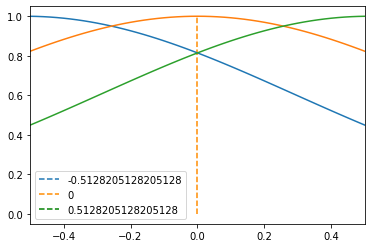

In [54]:
# for plotting
def gauss(x, j):
    return np.exp(-0.5*((x - j*gx)/sigma)**2)

# this should insure that regardless of how many bases
# we use the overlate will be about the same
# fracmax sets at what fraction of the maximum hight
# we want our basis Gaussians to overlap
fracmax = .95
sigma = gx / (2 * np.sqrt(2 * np.log(1/fracmax) ) ) 
print(sigma)



plt.plot(xvec, gauss(xvec,-1))
plt.vlines(-1*gx, ymin=0, ymax=1, label=-1*gx, linestyles='dashed')
plt.plot(xvec, gauss(xvec,0))
plt.vlines(0, ymin=0, ymax=1, label=0, color='darkorange', linestyles='dashed')
plt.plot(xvec, gauss(xvec,1))
plt.vlines(gx, ymin=0, ymax=1, label=gx, color='green', linestyles='dashed')
plt.xlim([-0.5,0.5])
plt.legend()
plt.show()

In [85]:
fracmax = 0.95 # 0.80
sigma = gx / (2 * np.sqrt(2 * np.log(1/fracmax) ) ) 

# We want a matrix which is constructed by evaluating
# each of the shifted Gaussians at all of the spacial
# grid points
# Here we have one Gaussian centered at each spacial
# grid point
# gmat = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xx,1))**2 / sigma)
# Because of broadcasting we only need to expand one of the arrays
# so that thegmat = np.exp(-(xx - np.expand_dims(xx,1))**2 / sigma) dimension is (#, 1)
# gmat = np.exp(-(xx - np.expand_dims(xx,1))**2 / sigma)
gmat = np.exp(-0.5*((xx - np.expand_dims(xx,1))/sigma)**2)
print(gmat.shape)
np.linalg.cond(gmat)

(40, 40)


68129.5026140817

In [86]:
Nfine = N*2
xvecfine, dxfine = np.linspace(-l, l, Nfine, retstep=True)
# gmatplot = np.exp(-(np.expand_dims(xx,0) - np.expand_dims(xvec,1))**2 / sigma)
gmatplot = np.exp(-0.5*((xx - np.expand_dims(xvecfine, 1))/sigma)**2)
print(gmatplot.shape)

(2002, 40)


In [87]:
def myfunc(x):
    # out = (x < -3)*(x+3)**3/350 + ((x >= -3) & (x < 6))*(np.exp(-x - 3) - 1) + (x >= 6)*(np.exp(-9) - 1 + (x-6)**2/14)
    out = 2*np.cos(x) + np.sin(5*x)
    # harmonic potential
    # out = 0.5 * x**2
    # double well potential
    # out = 0.5 * (x**2 - 4)**2
    # soft Coulomb
    # out = 1 / np.sqrt(1 + (x - 10)**2)
    return out

In [88]:
coefs = np.linalg.inv(gmat) @ myfunc(xx)

In [89]:
#coefs

0.0329797955487259


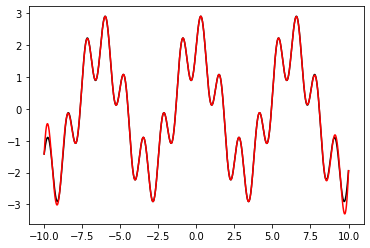

In [90]:
myfuncapprox = gmatplot @ coefs

print(dxfine*np.linalg.norm(myfunc(xvecfine) - myfuncapprox))

plt.plot(xvecfine, myfunc(xvecfine), '-', color='black')

plt.plot(xvecfine, myfuncapprox, '-', color='red')
plt.show()